## PREPROCESSING

In [123]:
import pandas as pd
import os
from sklearn import preprocessing
from collections import deque
import numpy as np
import random
import time
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

In [124]:
SEQ_LEN = 60
FUTURE_PERIOD_PREDICT = 3
RATIO_TO_PREDICT = "LTC-USD"
EPOCHS = 3
BATCH_SIZE = 64
NAME = f"{RATIO_TO_PREDICT}-{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"

In [125]:
path = "C:\\Dosyalar\\stuff\\ders\\csv files\\crypto_data\\"
main_df = pd.DataFrame()
ratios = ['BTC-USD', 'LTC-USD', 'ETH-USD', 'BCH-USD']

for ratio in ratios:
    dataset = path+ratio+'.csv'
    df = pd.read_csv(dataset, names = ['time','low','high','open','close','volume'])
    #print(df.head())
    df.rename(columns={"close": f"{ratio}_close", "volume": f"{ratio}_volume"}, inplace=True)
    df.set_index("time", inplace=True)
    df = df[[f"{ratio}_close", f"{ratio}_volume"]]
    #print(df.head())

    if len(main_df) == 0:
        main_df = df
    else: main_df = main_df.join(df)

print(main_df.head())

            BTC-USD_close  BTC-USD_volume  LTC-USD_close  LTC-USD_volume  \
time                                                                       
1528968660    6489.549805        0.587100      96.580002        9.647200   
1528968720    6487.379883        7.706374      96.660004      314.387024   
1528968780    6479.410156        3.088252      96.570000       77.129799   
1528968840    6479.410156        1.404100      96.500000        7.216067   
1528968900    6479.979980        0.753000      96.389999      524.539978   

            ETH-USD_close  ETH-USD_volume  BCH-USD_close  BCH-USD_volume  
time                                                                      
1528968660            NaN             NaN     871.719971        5.675361  
1528968720      486.01001       26.019083     870.859985       26.856577  
1528968780      486.00000        8.449400     870.099976        1.124300  
1528968840      485.75000       26.994646     870.789978        1.749862  
1528968900      4

In [126]:
def classify(current, future):
    if float(future) > float(current):
        return 1
    else:
        return 0


def preprocess_df(df):
    df = df.drop("future", 1)
    for col in df.columns:
        if col != "target":
            df[col] = df[col].pct_change()
            df.dropna(inplace=True)
            df[col] = preprocessing.scale(df[col].values)

    df.dropna(inplace=True)

    sequential_data = []
    prev_days = deque(maxlen = SEQ_LEN)
    for i in df.values:
         prev_days.append([n for n in i[:-1]])
         if len(prev_days) == SEQ_LEN:
            sequential_data.append([np.array(prev_days), i[-1]])

    random.shuffle(sequential_data)

    buys = []
    sells = []

    for seq, target in sequential_data:
        if target == 0:
            sells.append([seq, target])
        elif target == 1:
            buys.append([seq, target])

    random.shuffle(buys)
    random.shuffle(sells)

    lower = min(len(buys), len(sells))
    buys = buys[:lower]
    sells = sells[:lower]

    sequential_data = buys+sells
    random.shuffle(sequential_data)

    X = []
    y = []

    for seq, target in sequential_data:
        X.append(seq)
        y.append(target)

    return np.array(X), y

In [127]:
main_df['future'] = main_df[f"{RATIO_TO_PREDICT}_close"].shift(-FUTURE_PERIOD_PREDICT)
print(main_df[[f"{RATIO_TO_PREDICT}_close", "future"]].head())

            LTC-USD_close     future
time                                
1528968660      96.580002  96.500000
1528968720      96.660004  96.389999
1528968780      96.570000  96.519997
1528968840      96.500000  96.440002
1528968900      96.389999  96.470001


In [128]:
main_df["target"] = list(map(classify, main_df[f"{RATIO_TO_PREDICT}_close"], main_df["future"]))
print(main_df[[f"{RATIO_TO_PREDICT}_close", "future" , "target"]].head(10))

            LTC-USD_close     future  target
time                                        
1528968660      96.580002  96.500000       0
1528968720      96.660004  96.389999       0
1528968780      96.570000  96.519997       0
1528968840      96.500000  96.440002       0
1528968900      96.389999  96.470001       1
1528968960      96.519997  96.400002       0
1528969020      96.440002  96.400002       0
1528969080      96.470001  96.400002       0
1528969140      96.400002  96.400002       0
1528969200      96.400002  96.400002       0


In [129]:
times = sorted(main_df.index.values)
last_5pct = times[-int(0.05*len(times))]
print(last_5pct)

1534922100


In [130]:
validation_main_df = main_df[(main_df.index >= last_5pct)]
main_df = main_df[(main_df.index < last_5pct)]

train_x, train_y = preprocess_df(main_df)
validation_x, validation_y = preprocess_df(validation_main_df)
# train_x = tf.keras.utils.normalize(train_x, axis=1)
# validation_x = tf.keras.utils.normalize(validation_x, axis=1)

print(f"train data: {len(train_x)} validation: {len(validation_x)}")
print(f"Dont buys: {train_y.count(0)}, buys: {train_y.count(1)}")
print(f"VALIDATION Dont buys: {validation_y.count(0)}, buys: {validation_y.count(1)}")

C:\Users\enest\AppData\Local\Temp\ipykernel_13960\2925328859.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.drop("future", 1)


train data: 69188 validation: 3062
Dont buys: 34594, buys: 34594
VALIDATION Dont buys: 1531, buys: 1531


C:\Users\enest\AppData\Local\Temp\ipykernel_13960\2925328859.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.drop("future", 1)


## MODEL

In [131]:
model = Sequential()
model.add(LSTM(128, input_shape = (train_x.shape[1:]), return_sequences = True))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(LSTM(128, input_shape = (train_x.shape[1:]),return_sequences = True))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(LSTM(128, input_shape = (train_x.shape[1:])))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(32, activation = "relu"))
model.add(Dropout(0.2))

model.add(Dense(2, activation = 'softmax'))

In [133]:
opt = tf.keras.optimizers.Adam(lr = 0.001, decay = 1e-6)
model.compile(
    loss = "sparse_categorical_crossentropy", 
    optimizer = opt, 
    metrics = ["accuracy"])

tensorboard = TensorBoard(log_dir=f"logs\\{NAME}")
#do like this, next time ----> tensorboard = TensorBoard(log_dir=f"logs/{NAME}")
filepath = "RNN_Final-{epoch:02d}-{val_accuracy:.3f}"
checkpoint = ModelCheckpoint("models\\{}.model".format(filepath, monitor = "val_accuracy", verbose = 1, save_best_only = True, mode = "max"))

train_x = np.asarray(train_x)
train_y = np.asarray(train_y)
validation_x = np.asarray(validation_x)
validation_y = np.asarray(validation_y)
history = model.fit(
    train_x, train_y,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = (validation_x, validation_y),
    callbacks = [tensorboard, checkpoint])

Epoch 1/3
1082/1082 [==============================] - ETA: 0s - loss: 0.6899 - accuracy: 0.5370

INFO:tensorflow:Assets written to: models\RNN_Final-01-0.559.model\assets


INFO:tensorflow:Assets written to: models\RNN_Final-01-0.559.model\assets


1082/1082 [==============================] - 299s 272ms/step - loss: 0.6899 - accuracy: 0.5370 - val_loss: 0.6877 - val_accuracy: 0.5588
Epoch 2/3
1082/1082 [==============================] - ETA: 0s - loss: 0.6847 - accuracy: 0.5582

INFO:tensorflow:Assets written to: models\RNN_Final-02-0.563.model\assets


INFO:tensorflow:Assets written to: models\RNN_Final-02-0.563.model\assets


1082/1082 [==============================] - 311s 287ms/step - loss: 0.6847 - accuracy: 0.5582 - val_loss: 0.6824 - val_accuracy: 0.5634
Epoch 3/3
1082/1082 [==============================] - ETA: 0s - loss: 0.6828 - accuracy: 0.5611

INFO:tensorflow:Assets written to: models\RNN_Final-03-0.569.model\assets


INFO:tensorflow:Assets written to: models\RNN_Final-03-0.569.model\assets


1082/1082 [==============================] - 312s 288ms/step - loss: 0.6828 - accuracy: 0.5611 - val_loss: 0.6808 - val_accuracy: 0.5689


# CHECK THE TENSORBOARD GRAPHS

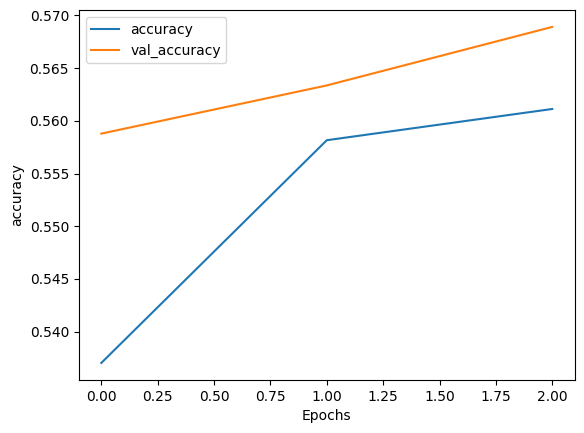

In [136]:
#looking the graphs
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history["val_"+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, "val_"+string])
    plt.show()

plot_graphs(history, "accuracy")

In [145]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

# Create a TensorBoard object and specify the log directory
tensorboard = tf.keras.callbacks.TensorBoard(log_dir='logs')

# View the TensorBoard in Jupyter Notebook
%tensorboard --logdir logs


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 16336), started 0:16:01 ago. (Use '!kill 16336' to kill it.)

In [144]:
log_dir = "S:\\Projects\\Time Series\\logs"
summary_writer = tf.summary.create_file_writer(log_dir)

# SENTDEX